### 7-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

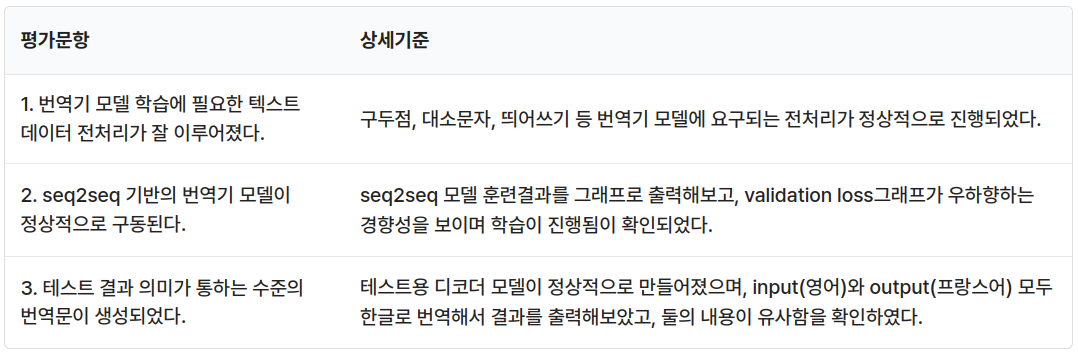



- 주요 라이브러리 버전을 확인

In [17]:
import tensorflow
import pandas as pd 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

print(tensorflow.__version__)

2.6.0


- 실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기. 하지만 실제 번역기는 Word-level이 더 보편적.
  
   ■ Word-level 번역기
  
   ○ 글자 단위와는 다른 전처리,  to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 완성.
   
   ○ 글자 단위보다 단어장의 크기 커지고, 학습속도 더 느려짐. 
   
   
   
   
- 학습과 테스트시 상위 33,000개의 샘플만 사용.그중 3000개는 테스트 데이터로 분리, 모델을 학습한 후에 번역을 테스트.





### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)


- 글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요.

  1. 구두점(Punctuation)을 단어와 분리.

   ■ 영어권 언어의 경우 띄어쓰기 단위로 단어분리. 
   
   ■ 토큰화(Tokenization) 어디까지가 하나의 단어인지를 구분하는 작업, 
   
   ■ 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있다.
   
    
   

   2. 소문자로 바꿈.
   
   기계는 대문자,소문자는 서로 다른 단어.


  3. 띄어쓰기 단위로 토큰화 수행.  
  
     기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식. !는 boy와 붙어있는 한 단어X

     토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']
      


- 해당 파일을 데이터프레임으로 읽어옴.

In [18]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 208906


,eng,fra,cc
159891,Please turn left at the first corner.,"Tournez à gauche au premier coin de rue, s'il ...",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
202556,I'm going to put them in a room and let them b...,Je vais les mettre dans une pièce et les laiss...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
53575,Many people are upset.,De nombreuses personnes sont contrariées.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
38873,Let's try this cake.,Essayons ce gâteau.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
132374,The Ferris wheel is my favorite.,La grande roue est ma préférée.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [19]:
lines = lines[['eng', 'fra']][:33000] # 33,000개 샘플 사용
lines.sample(5)

,eng,fra
7503,I have cancer.,Je suis atteinte d’un cancer.
29994,Have you gone nuts?,Êtes-vous devenus fous ?
24628,I guess that's OK.,Je suppose que c'est d'accord.
27254,This is extortion.,C'est de l'extorsion.
23906,Has Tom eaten yet?,Est-ce que Tom a déjà mangé ?


In [20]:
lines_np_eng= lines['eng'].to_numpy()
lines_np_fra= lines['fra'].to_numpy()
lines_np_eng

array(['Go.', 'Go.', 'Go.', ..., 'That part was easy.',
       'That sounded weird.', 'That sounds lovely.'], dtype=object)

  ### 1. 구두점(Punctuation)을 단어와 분리.

In [21]:
def preprocess_line(line, plus_token = True):
    # 소문자로 변경하기
    line = line.lower().strip()
    # 구두점(Punctuation)을 단어와 분리하기
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ", line)

    line = line.strip()
    
    if plus_token == True:
        line = sos_token + line + eos_token
    
    return line

- 전처리 테스트

### 2.  소문자 전환 

In [22]:
lines = lines.applymap(str.lower) 
lines.sample(5)

,eng,fra
14314,i caught a cold.,j'ai attrapé un rhume.
30031,he called for help.,il a demandé de l'aide.
25900,it's a conspiracy.,c'est un complot.
28116,we're all friends.,nous sommes tous amis.
31619,i'm always careful.,je suis toujours prudent.


### 3. 띄어쓰기 단위로 토큰화 

In [23]:
def tokenize(corpus):
    tokenizer = Tokenizer(
        num_words=33000,  
        filters=' ',   
        oov_token="<unk>"  
    )
    tokenizer.fit_on_texts(corpus)  

    tensor = tokenizer.texts_to_sequences(corpus)   

    return tensor, tokenizer

In [24]:
eng_tokenizer = Tokenizer(char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[21], [21], [21]]

In [25]:
eng_tensor, eng_tokenizer = tokenize(eng_lines)
fra_tensor, fra_tokenizer = tokenize(fra_lines)
fra_tensor[:10]

[]

- 전체 데이터에서 33,000개의 샘플에 대해서 전처리를 수행. Teacher Forcing을 사용할 예정이므로, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값. 
  즉, 레이블에 해당되는 출력 시퀀스를 따로 분리하여 저장. 
  

### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰 추가.

- 입력 시퀀스에는 시작을 의미하는 토큰인 <sos>를 추가, 출력 시퀀스에는 종료를 의미하는 토큰인 <eos>를 추가
    
    
    
    

- 글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 <sos>가 필요. 그리고 교사 강요를 수행할 때, 
    
  디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 <eos>가 필요.
    
  예를 들어 번역 문장이 "Courez!" 였다고 한다면, Step 1을 거친 후에는 다음과 같은 결과.

  Step 1을 수행한 후 : ['courez', '!']
    
  이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

 입력 시퀀스 : ['<sos>', 'courez', '!']
 레이블 시퀀스 : ['courez', '!', '<eos>']
 참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없다!
 Step 1을 수행하는 중간에 수행해도 상관없다.


- 입력 시퀀스에는 시작을 의미하는 토큰인 <sos>를 추가, 출력 시퀀스에는 종료를 의미하는 토큰인 <eos>를 추가

In [26]:
sos_token = '<sos>'
eos_token = '<eos>'
lines.fra = lines.fra.apply(lambda x : '<sos> ' + x + ' <eos>')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
26408,plug that leak up.,<sos> bouche cette fuite. <eos>
31006,i like mathematics.,<sos> j'aime les mathématiques. <eos>
9513,what a hassle!,<sos> quelle histoire ! <eos>
17557,you sound angry.,<sos> tu as l'air en colère. <eos>
813,tom died.,<sos> tom est mort. <eos>


In [27]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

- 이렇게 얻은 3개의 데이터셋 인코더의 입력, 디코더의 입력, 디코더의 레이블을 상위 5개 샘플 출력

### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 .


- 딥러닝 모델은 텍스트가 아닌 숫자를 처리. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿈.



-https://wikidocs.net/31766 위키독스 케라스 토크나이저의 사용법, 케라스(Keras)의 텍스트 전처리




-영어와 프랑스어에 대한 토크나이저를 각각 생성하고, tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환.

In [28]:
fra_tokenizer = Tokenizer(char_level=False)  
fra_tokenizer.fit_on_texts(lines.fra)               
target_text = fra_tokenizer.texts_to_sequences(lines.fra)    
target_text[:3]

[[1, 58, 2], [1, 337, 2], [1, 22, 500, 2]]

In [29]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 2
프랑스어 단어장의 크기 : 9938


In [30]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


In [31]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 2
프랑스어 단어장의 크기 : 9938
영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


In [32]:
encoder_input = eng_tensor
# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index['<eos>']] for line in fra_tensor]
# 시작 토큰 제거
decoder_target =[[char for char in line if char != fra_tokenizer.word_index['<sos>']] for line in fra_tensor]

In [ ]:



Step 4. 임베딩 층(Embedding layer) 사용하기
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의 1. 케라스 임베딩 층(Keras Embedding layer) 을 참고하세요.

https://wikidocs.net/31766 위키독스
실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다. 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

from tensorflow.keras.layers import Input, Embedding, Masking

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
encoder_lstm = LSTM(hidden state의 크기, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 것입니다!

Step 5. 모델 구현하기
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요! 이때는 label이 integer 값이므로 categorical entropy loss가 아닌 sparse categorical entropy loss를 사용합니다.

Step 6. 모델 평가하기
단어 단위 번역기를 이용하여 훈련 데이터의 샘플과 테스트 데이터의 샘플로 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요. 이전 스텝들에서 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.
decode sentence를 구성할 때 고민해보세요!!



### Reference

- https://wikidocs.net/31766 케라스 토크나이저의 사용법

### 결론및 회고 